In [ ]:
# try to train CNN to classify different stages
# coding: utf-8

import numpy as np
import pandas as pd
import time, os, sys, glob, io
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy

mpl.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 22})

import cv2
from PIL import Image

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [46]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, KFold

In [48]:
now = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
RANDOM_SEED = 42
PATH = os.path.join(os.getcwd(), "experiments")

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [49]:
LOGFILE = os.path.join(PATH, now + '_training.log')

# Logging

header = []

# header.append('Current Time: %s' % now)
header.append('PyTorch Version: %s' % torch.__version__)
header.append('CUDA device available: %s' % torch.cuda.is_available())
header.append('Using CUDA device: %s' % device)
header.append('Random Seed: %s' % RANDOM_SEED)
header.append('Output Path: %s' % PATH)


with open(LOGFILE, 'w') as f:
    for entry in header:
        print(entry)
        f.write('%s\n' % entry)
        f.flush()

PyTorch Version: 1.7.1
CUDA device available: True
Using CUDA device: cuda:0
Random Seed: 42
Output Path: C:\Users\AChub_Lab\Desktop\my_project\experiments


In [27]:
def add2log(s):
    try:
        with io.open(LOGFILE, "a", encoding="utf-8") as f:
            f.write('%s\n' % s)
        print(s)
    except:
        print("not logged")

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [40]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        s = 'Epoch {}/{}'.format(epoch, num_epochs - 1)
        add2log(s)
        add2log('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            s = '{} Loss: {:.4f} | Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc)
            add2log(s)

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'valid':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    s = 'Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)
    add2log(s)
 
    add2log('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [14]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [15]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size



In [16]:
class MalariaDataset(Dataset):
    def __init__(self, data, transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_path,label = self.data[index]
        image = Image.open(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [9]:
# load data
path = r"C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMSO\train"
matches = []
for root, dirnames, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith(('.png')) and "cp" not in filename:
#             print (filename)
            matches.append(os.path.join(root, filename))
print (len(matches))

class_name = {"uninf": 0, 'ring': 1, 'troph': 2, 'shiz': 3}
df_train = pd.DataFrame(matches, columns = ["img_path"])

df_train.loc[:, "stage"] = df_train["img_path"].str.split("\\", expand = True)[8]
df_train.loc[:, "label"] = df_train["stage"].map(class_name)
# create a list of the values we want to assign for each condition

# create a new column and use np.select to assign values to it using our lists as arguments
df_train.head()

df_train = df_train.dropna()
df_train.groupby("label").count()

3978


,img_path,stage
label,,
0,1107,1107
1,828,828
2,857,857
3,1186,1186


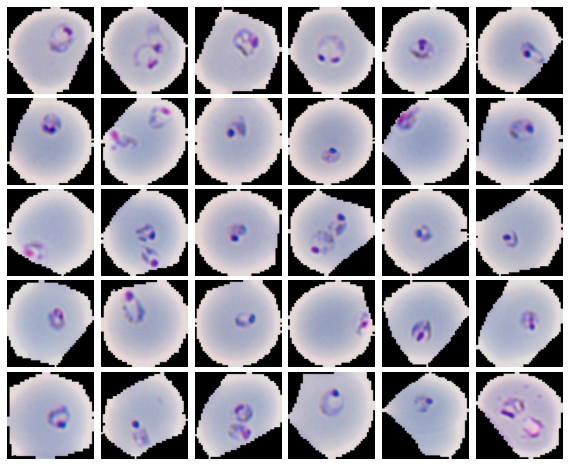

In [10]:
fig = plt.figure(figsize = (10,10))
gs1 = mpl.gridspec.GridSpec(6, 6)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

for idx, val in enumerate(df_train[df_train['label'] == 1]["img_path"][200:230]):
#     print (idx, val)
    ax = plt.subplot(gs1[idx])
    ax.axis("off")
    ax.set_aspect('equal')
    im = plt.imread(val)
    img_scaled = cv2.resize(im, (224, 224), interpolation = cv2.INTER_AREA)
    ax.imshow(img_scaled)

In [21]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "vgg"

# Number of classes in the dataset
num_classes = 4

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
add2log(model_name)
add2log("Number of trainable params: " + str(count_parameters(model_ft)))
add2log(str(summary(model_ft)))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (1,792)
|    └─BatchNorm2d: 2-2                  (128)
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Conv2d: 2-5                       (73,856)
|    └─BatchNorm2d: 2-6                  (256)
|    └─ReLU: 2-7                         --
|    └─MaxPool2d: 2-8                    --
|    └─Conv2d: 2-9                       (295,168)
|    └─BatchNorm2d: 2-10                 (512)
|    └─ReLU: 2-11                        --
|    └─Conv2d: 2-12                      (590,080)
|    └─BatchNorm2d: 2-13                 (512)
|    └─ReLU: 2-14                        --
|    └─MaxPool2d: 2-15                   --
|    └─Conv2d: 2-16                      (1,180,160)
|    └─BatchNorm2d: 2-17                 (1,024)
|    └─ReLU: 2-18                        --
|    └─Conv2d: 2-19                      (2,359,808)
|    └─Batc

In [147]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
#         transforms.RandomResizedCrop((input_size, input_size), scale=(0.8, 1.0)),
        transforms.Resize((input_size, input_size)),
        torchvision.transforms.ColorJitter(brightness=0.1, contrast=.1, saturation=.1, hue=.4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(20, resample = Image.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((input_size, input_size)),
#         transforms.CenterCrop((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [148]:
batch_size = 32
train_data, valid_data = train_test_split(df_train[["img_path", "label"]], stratify=df_train["label"], test_size=0.2)
image_datasets =  { "train" : MalariaDataset(train_data, data_transforms["train"]), 
                     "valid": MalariaDataset(valid_data, data_transforms["valid"]) }
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

dataloaders = {"train": DataLoader(dataset = image_datasets["train"], batch_size = batch_size, shuffle=True, num_workers=0), 
              "valid": DataLoader(dataset = image_datasets["valid"], batch_size = batch_size, shuffle=False, num_workers=0)}

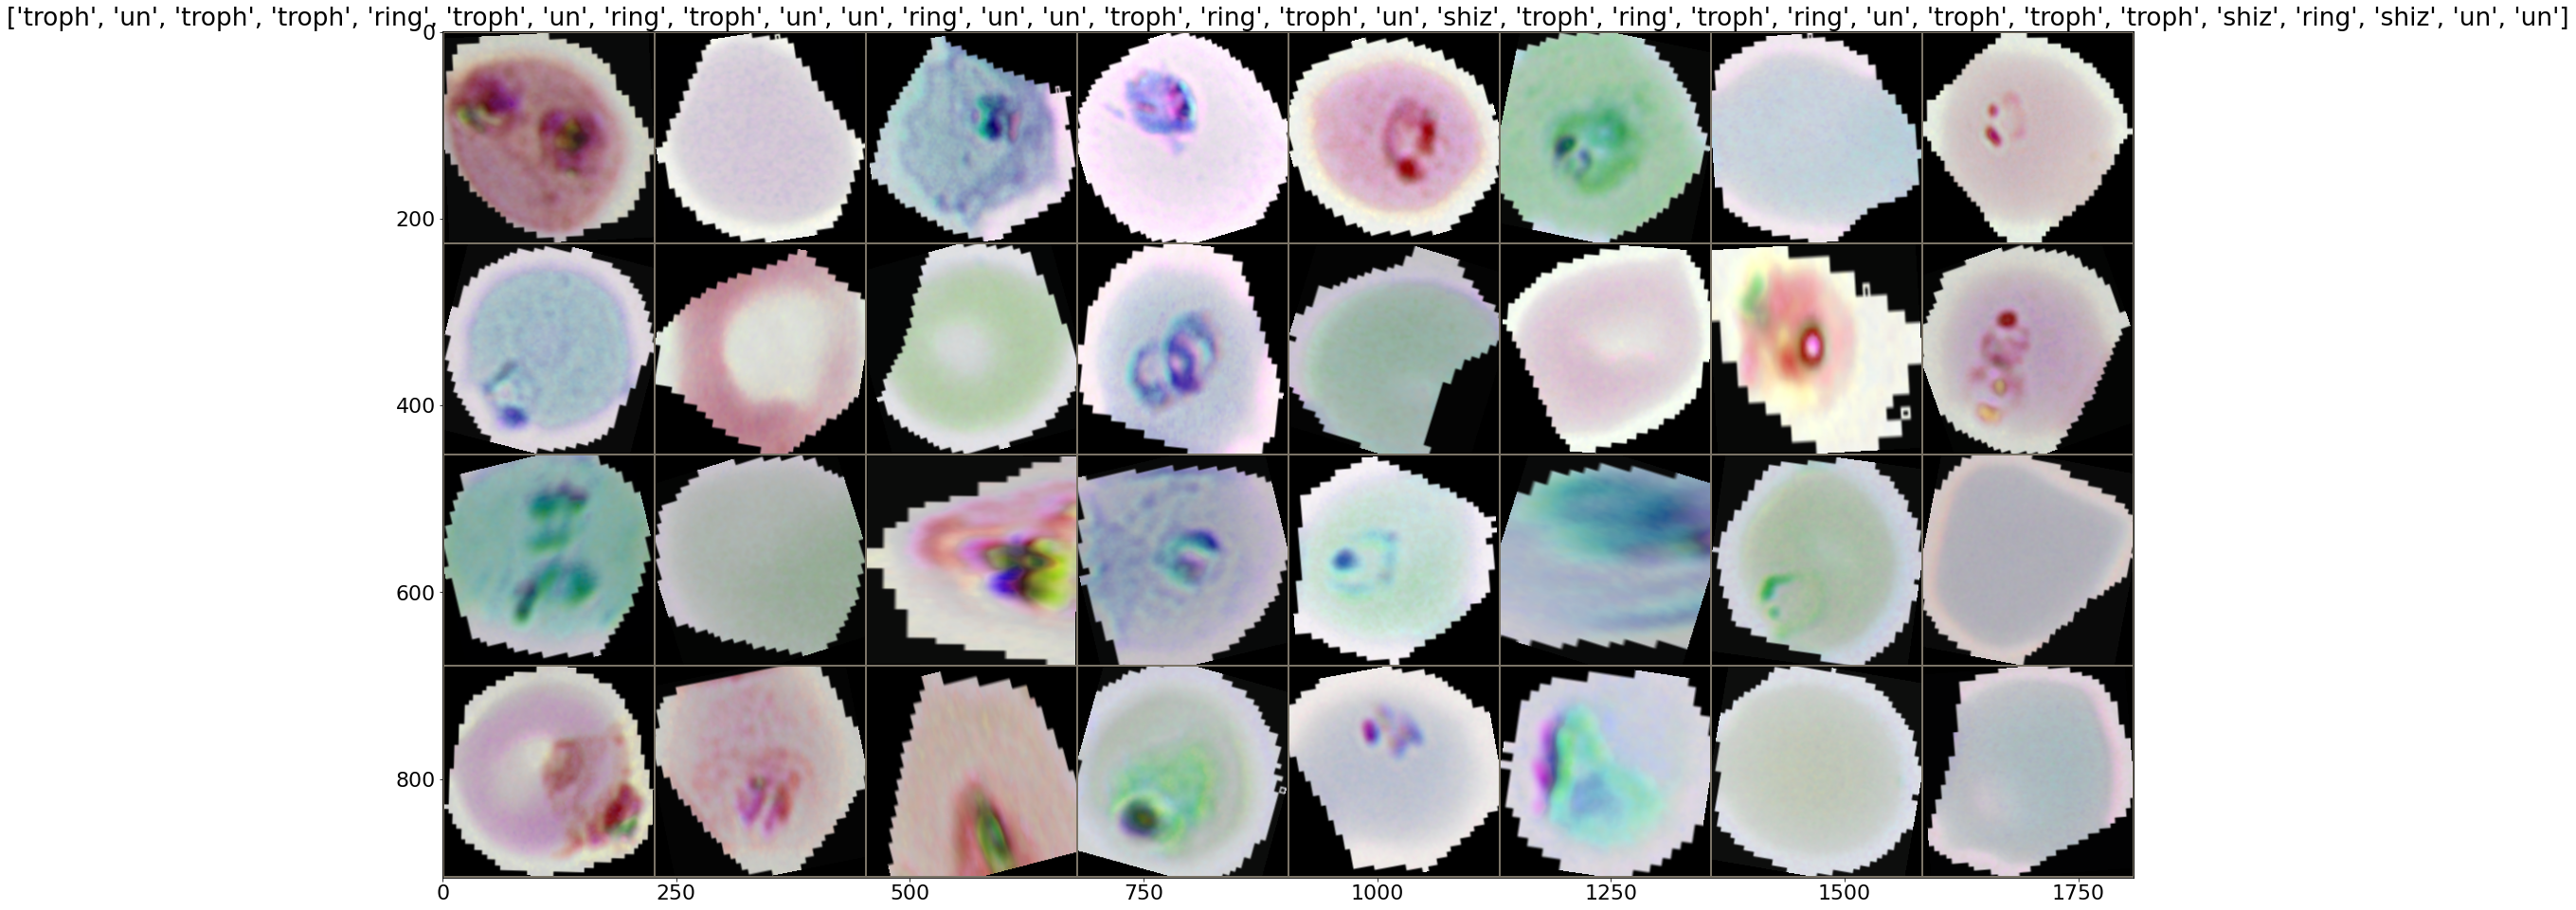

In [149]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

fig = plt.figure(figsize = (32, 32))
# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))
class_name_ls = ["un", 'ring', 'troph', 'shiz']
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_name_ls[x] for x in classes.int()])

In [33]:
model_ft = model_ft.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()))
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()


In [39]:
# Train and evaluate
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()))
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, 
                             num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------
train Loss: 0.7516 | Acc: 0.6870
train Loss: 0.7516 | Acc: 0.6870
valid Loss: 0.6155 | Acc: 0.7487
valid Loss: 0.6155 | Acc: 0.7487

Epoch 1/14
----------
train Loss: 0.7368 | Acc: 0.7040
train Loss: 0.7368 | Acc: 0.7040
valid Loss: 0.5350 | Acc: 0.7776
valid Loss: 0.5350 | Acc: 0.7776

Epoch 2/14
----------
train Loss: 0.7332 | Acc: 0.7011
train Loss: 0.7332 | Acc: 0.7011
valid Loss: 0.5157 | Acc: 0.7877
valid Loss: 0.5157 | Acc: 0.7877

Epoch 3/14
----------
train Loss: 0.6855 | Acc: 0.7187
train Loss: 0.6855 | Acc: 0.7187
valid Loss: 0.5656 | Acc: 0.7739
valid Loss: 0.5656 | Acc: 0.7739

Epoch 4/14
----------
train Loss: 0.6979 | Acc: 0.7212
train Loss: 0.6979 | Acc: 0.7212
valid Loss: 0.5241 | Acc: 0.7714
valid Loss: 0.5241 | Acc: 0.7714

Epoch 5/14
----------
train Loss: 0.6816 | Acc: 0.7190
train Loss: 0.6816 | Acc: 0.7190
valid Loss: 0.4236 | Acc: 0.8279
valid Loss: 0.4236 | Acc: 0.8279

Epoch 6/14
----------
train Loss: 0.6818 | Acc: 0.7143
train Loss: 0.6

In [51]:
# Set fixed random number seed
k_folds = 5
dataset = df_train[["img_path", "label"]]

kfold = KFold(n_splits=k_folds, shuffle=True)
results = {}

# Number of classes in the dataset
num_classes = 4
# Batch size for training (change depending on how much memory you have)
batch_size = 32
# Number of epochs to train for
num_epochs = 15
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True
models_ls = ["resnet", "vgg", "alexnet", "squeezenet", "densenet"]

for m in models_ls[:]:
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    #     print (fold, len(train_ids) , len(test_ids))
        image_datasets = {}
        dataloaders = {}
        add2log(f'FOLD {fold}')
        add2log('||||||||||||')

        image_datasets =  { "train" : MalariaDataset(dataset.loc[train_ids], data_transforms["train"]), 
                             "valid": MalariaDataset(dataset.loc[test_ids], data_transforms["valid"]) }
        dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

        dataloaders = {"train": DataLoader(dataset = image_datasets["train"], batch_size = batch_size, shuffle=True, num_workers=0), 
                      "valid": DataLoader(dataset = image_datasets["valid"], batch_size = batch_size, shuffle=False, num_workers=0)}

        # Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
        model_name = m

        # Initialize the model for this run
        model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

        # Print the model we just instantiated
        add2log(model_name)
#         add2log("Number of trainable params: " + str(count_parameters(model_ft)))
        add2log(str(summary(model_ft)))

        model_ft = model_ft.to(device)

        # Observe that all parameters are being optimized
        optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()))
        # Decay LR by a factor of 0.1 every 7 epochs
        # exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
        # Setup the loss fxn
        criterion = nn.CrossEntropyLoss()

        # Train and evaluate
        model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, 
                                 num_epochs=num_epochs, is_inception=(model_name=="inception"))
        # Saving the model
        save_path = f'.models/{m}-fold-{fold}.pth'
        torch.save(model_ft.state_dict(), save_path)
        break

FOLD 0
||||||||||||
resnet
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  (36,864)
|    |    └─BatchNorm2d: 3-2             (128)
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  (36,864)
|    |    └─BatchNorm2d: 3-5             (128)
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  (36,864)
|    |    └─BatchNorm2d: 3-7             (128)
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  (36,864)
|    |    └─BatchNorm2d: 3-10            (128)
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 (73

train Loss: 0.6765 | Acc: 0.7338
valid Loss: 0.5070 | Acc: 0.7827

Training complete in 6m 58s
Best val Acc: 0.826633
FOLD 0
||||||||||||


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\AChub_Lab/.cache\torch\hub\checkpoints\alexnet-owt-4df8aa71.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

alexnet
Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (23,296)
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Conv2d: 2-4                       (307,392)
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
|    └─Conv2d: 2-7                       (663,936)
|    └─ReLU: 2-8                         --
|    └─Conv2d: 2-9                       (884,992)
|    └─ReLU: 2-10                        --
|    └─Conv2d: 2-11                      (590,080)
|    └─ReLU: 2-12                        --
|    └─MaxPool2d: 2-13                   --
├─AdaptiveAvgPool2d: 1-2                 --
├─Sequential: 1-3                        --
|    └─Dropout: 2-14                     --
|    └─Linear: 2-15                      (37,752,832)
|    └─ReLU: 2-16                        --
|    └─Dropout: 2-17                     --
|    └─Linear: 2-18

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\AChub_Lab/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

densenet
Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (9,408)
|    └─BatchNorm2d: 2-2                  (128)
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─_DenseBlock: 2-5                  --
|    |    └─_DenseLayer: 3-1             (45,440)
|    |    └─_DenseLayer: 3-2             (49,600)
|    |    └─_DenseLayer: 3-3             (53,760)
|    |    └─_DenseLayer: 3-4             (57,920)
|    |    └─_DenseLayer: 3-5             (62,080)
|    |    └─_DenseLayer: 3-6             (66,240)
|    └─_Transition: 2-6                  --
|    |    └─BatchNorm2d: 3-7             (512)
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  (32,768)
|    |    └─AvgPool2d: 3-10              --
|    └─_DenseBlock: 2-7                  --
|    |    └─_DenseLayer: 3-11            (53,760)
|    |    └─_DenseLayer: 3-12            (57,92

In [ ]:
pd.DataFrame.from_dict({(i,j): results[i][j] 
                           for i in results.keys() 
                           for j in results[i].keys()},
                       orient='index')

In [150]:
model_ft, input_size = initialize_model("squeezenet", num_classes, feature_extract, use_pretrained=True)
model_ft.to(device)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [59]:
model_path = r"C:\Users\AChub_Lab\Desktop\my_project\Experiments\squeezenet-fold-0.pth"
model_ft.load_state_dict(torch.load(model_path))
model_ft.eval()
model_ft.to(device)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [152]:
# unfreeze top layers of convent
# note: firstly train head of the net
curr_layer = 0
layer_to_unfreeze = 48
for param in model_ft.parameters():
    curr_layer+=1
    if curr_layer >= layer_to_unfreeze:
        print (curr_layer, "child", param.shape)
#         continue
#         for param in child.parameters():
        param.requires_grad = True
        
#         add2log(child)


add2log("Number of trainable params: " + str(count_parameters(model_ft)))

48 child torch.Size([256])
49 child torch.Size([256, 64, 3, 3])
50 child torch.Size([256])
51 child torch.Size([4, 512, 1, 1])
52 child torch.Size([4])
Number of trainable params: 150020


In [119]:
add2log("Number of trainable params: " + str(count_parameters(model_ft)))

Number of trainable params: 2052


In [153]:
num_epochs = 30
# model_ft.to(device)
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr = 0.001)
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, 
                             num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/29
----------
train Loss: 0.3533 | Acc: 0.8696
valid Loss: 0.3156 | Acc: 0.8920

Epoch 1/29
----------
train Loss: 0.3222 | Acc: 0.8840
valid Loss: 0.3233 | Acc: 0.8957

Epoch 2/29
----------
train Loss: 0.3009 | Acc: 0.8891
valid Loss: 0.2874 | Acc: 0.9058

Epoch 3/29
----------
train Loss: 0.2991 | Acc: 0.8847
valid Loss: 0.2851 | Acc: 0.9008

Epoch 4/29
----------
train Loss: 0.2809 | Acc: 0.8966
valid Loss: 0.3030 | Acc: 0.8882

Epoch 5/29
----------
train Loss: 0.2818 | Acc: 0.9019
valid Loss: 0.3739 | Acc: 0.8631

Epoch 6/29
----------
train Loss: 0.2740 | Acc: 0.8972
valid Loss: 0.2712 | Acc: 0.9058

Epoch 7/29
----------
train Loss: 0.2634 | Acc: 0.9045
valid Loss: 0.2890 | Acc: 0.8932

Epoch 8/29
----------
train Loss: 0.2475 | Acc: 0.9054
valid Loss: 0.3060 | Acc: 0.8869

Epoch 9/29
----------
train Loss: 0.2506 | Acc: 0.9085
valid Loss: 0.2649 | Acc: 0.8982

Epoch 10/29
----------
train Loss: 0.2440 | Acc: 0.9098
valid Loss: 0.2850 | Acc: 0.8945

Epoch 11/29
--------

In [116]:
model_ft

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

### Test the model

In [52]:
test_path = r"C:\Users\AChub_Lab\Desktop\my_project\cell_images\cell_images"
matches = []
for root, dirnames, filenames in os.walk(test_path):
    for filename in filenames:
        if filename.endswith(('.png', ".PNG")):
#             print (filename)
            matches.append(os.path.join(root, filename))
print (len(matches))

27545


In [53]:
df_test = pd.DataFrame(matches, columns = ["img_path"])
stage = df_test["img_path"].str.split("\\", expand = True)[7]
df_test.loc[:, "stage"] = stage

def add_label(row):
    if row['stage'] == "Parasitized":
        return 1
    if row['stage'] == 'Uninfected':
        return 0
    return 'Other'
df_test.loc[:, "label"] = df_test.apply (lambda row: add_label(row), axis=1)

df_test.head()

,img_path,stage,label
0,C:\Users\AChub_Lab\Desktop\my_project\cell_ima...,Parasitized,1
1,C:\Users\AChub_Lab\Desktop\my_project\cell_ima...,Parasitized,1
2,C:\Users\AChub_Lab\Desktop\my_project\cell_ima...,Parasitized,1
3,C:\Users\AChub_Lab\Desktop\my_project\cell_ima...,Parasitized,1
4,C:\Users\AChub_Lab\Desktop\my_project\cell_ima...,Parasitized,1


In [54]:
df_test.groupby("label").count()

,img_path,stage
label,,
0,13779,13779
1,13766,13766


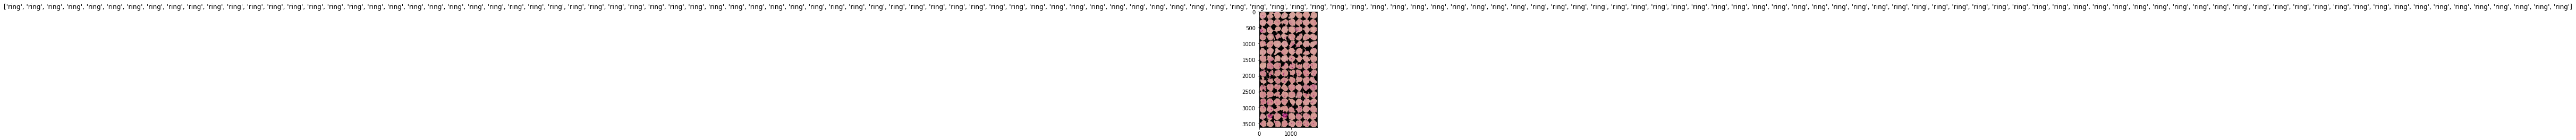

In [61]:
test_dataset =  MalariaDataset(df_test[["img_path", "label"]], data_transforms["valid"])
                     
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
batch_size = 128
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=False, num_workers=0)

inputs, classes = next(iter(test_loader))
class_names = ["un", 'ring', 'troph', 'shiz']
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



In [146]:
# test-the-model
model = model_ft.eval()
all_preds = []
test_labels = []
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        predicted = predicted.cpu().numpy()
       
        labels = labels.cpu().numpy()
        all_preds.append(predicted)
        test_labels.append(labels)
        
        predicted_clip = np.clip(predicted, 0, 1)
        total += labels.size
        correct += (predicted_clip == labels).sum().item()
        
#         false_idx = ((predicted == labels) == 0).nonzero()
#         if len(false_idx) > 0:
#             print (predicted[false_idx].flatten())
#             print (labels[false_idx].flatten())
    s = 'Test Accuracy of the model: {:.4f} %'.format(100 * correct / total)
#     print (s)
    add2log(s)
# Save 
# torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model: 88.1830 %


In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [65]:
plt.rcParams.update({'font.size': 22})

Text(0.5, 59.0, 'Predicted label')

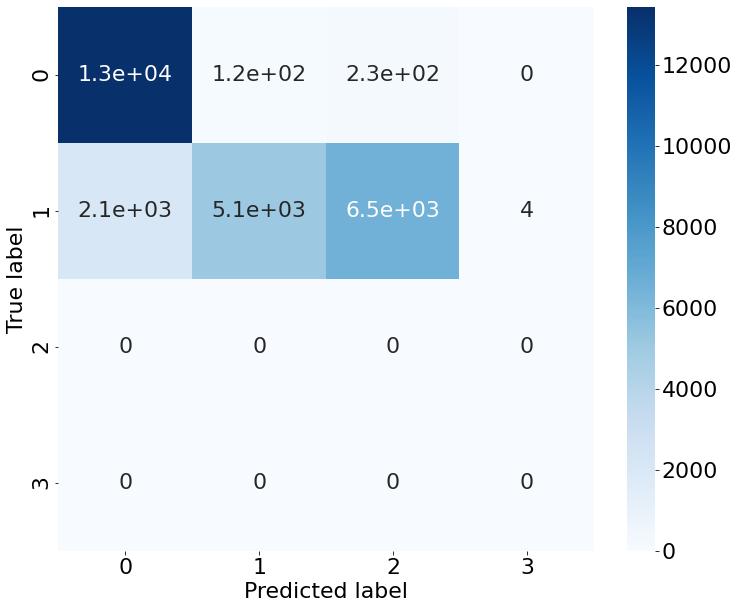

In [144]:
cm = confusion_matrix(np.concatenate(test_labels), np.concatenate(all_preds))
fig = plt.figure(figsize = (12,10))
sns.heatmap(cm, annot = True, cmap = "Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.savefig("confusion_matrix.png")

In [142]:
preds = np.concatenate(all_preds)
df_test.loc[:, "preds"] = preds

4


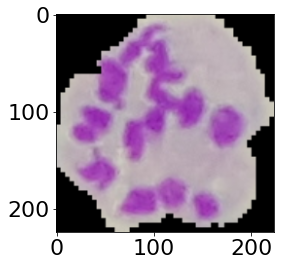

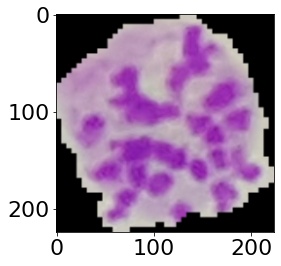

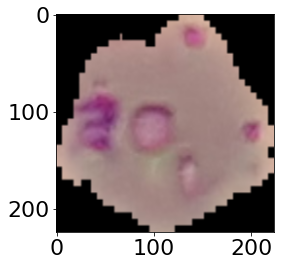

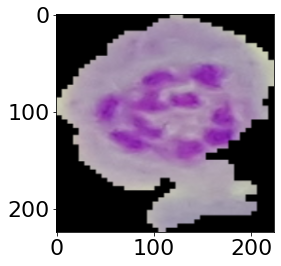

In [143]:
img_list = df_test[(df_test.preds == 3) & (df_test.label == 1)].img_path
print (len(img_list))
for fname in img_list[:]:
    im = plt.imread(fname)
    im = cv2.resize(im, (224,224))
    plt.imshow(im)
    plt.show()
    